In [4]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    colab_compat = True # deactivate preview
except:
    colab_compat = False
resolution = [480,320] # increase for higher quality of renderings

# Allows to exit cell execution in Jupyter
class ExitCell(Exception):
    def _render_traceback_(self):
        pass

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import yaml
import time

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera

# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement

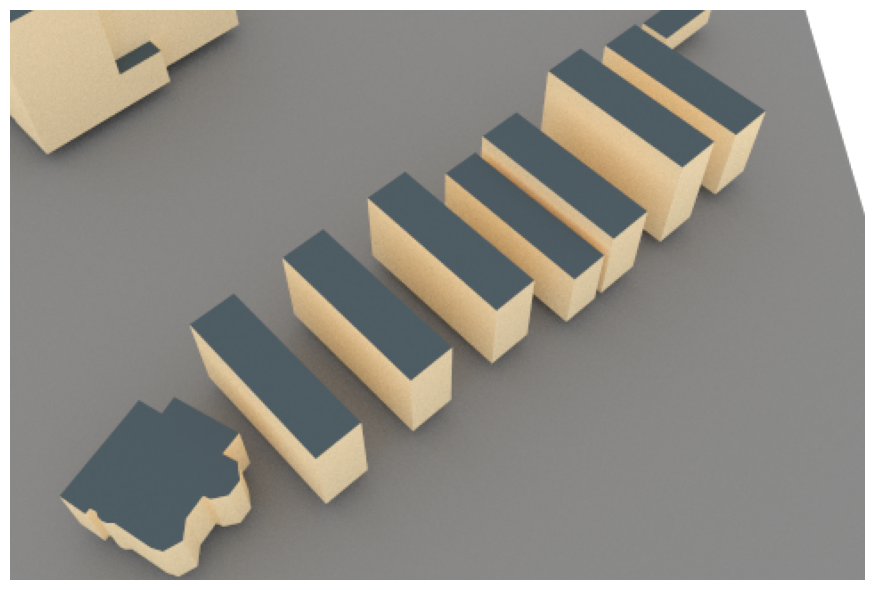

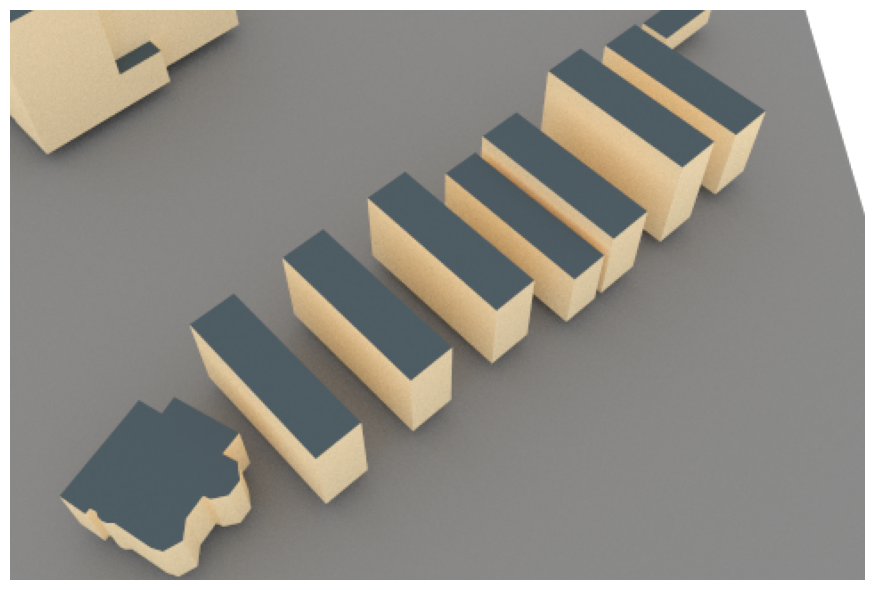

In [6]:
scene = load_scene("Blender/try_scene/untitled.xml")

cam_TxRx = Camera("cam_TxRx", position=[0, 100, 150], look_at=[0, 0, 0])
scene.add(cam_TxRx)

# Visualize paths in the 3D preview
scene.render("cam_TxRx",  resolution=resolution, num_samples=512)

In [16]:
for i, obj in enumerate(scene.objects.values()):
    print(f"{obj.name} : {obj.radio_material.name})")
    if i >= 10:
        break

Plane : itu_concrete)
element-itu_marble : itu_marble)
element-itu_metal : itu_metal)
溫室-itu_marble : itu_marble)
溫室-itu_metal : itu_metal)
溫室_001-itu_marble : itu_marble)
溫室_001-itu_metal : itu_metal)
溫室_002-itu_marble : itu_marble)
溫室_002-itu_metal : itu_metal)
溫室_003-itu_marble : itu_marble)
溫室_003-itu_metal : itu_metal)


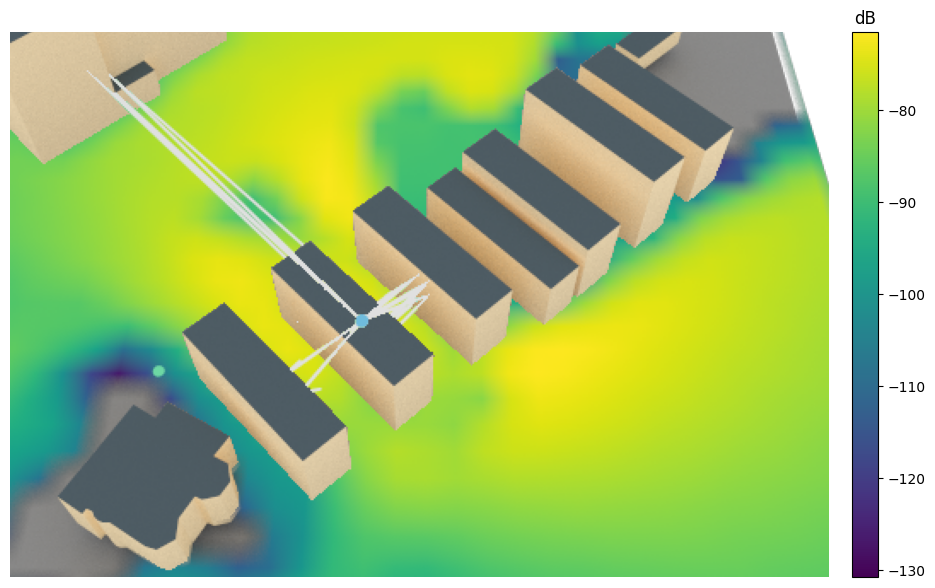

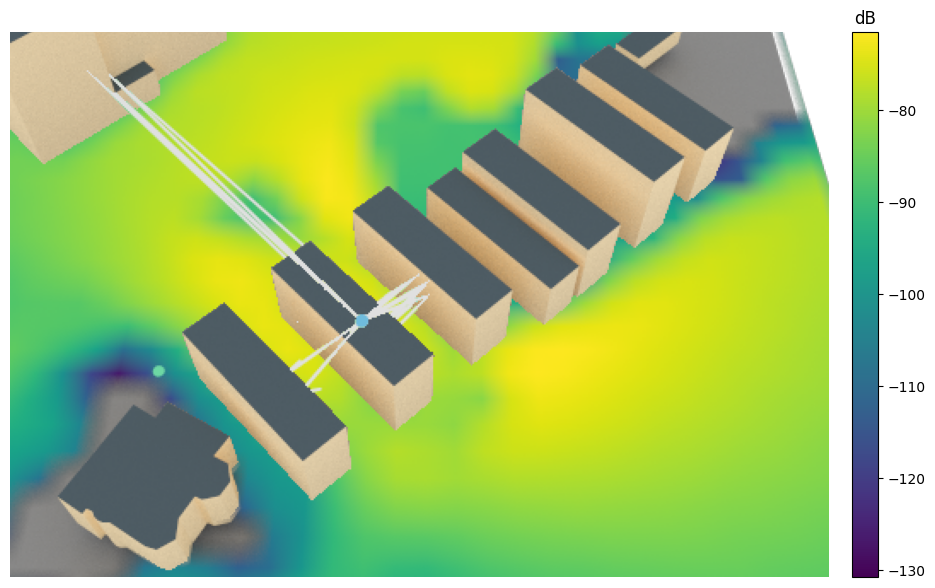

In [33]:
import yaml

# Function to load coordinates from YAML file
def load_coordinates(file_path):
    with open(file_path, 'r') as file:
        coordinates = yaml.safe_load(file)
    return coordinates

# Load coordinates from YAML file
coordinates = load_coordinates("coordinates.yml")

# Assuming you have already imported necessary classes and functions for Sionna

# Load scene from XML file
scene = load_scene("Blender/try_scene/untitled.xml")
resolution = [480, 320]

# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="cross")

# Extract coordinates from loaded YAML
tx_position = coordinates['tx_coordinates'][0]
rx_positions = coordinates['rx_coordinates']

# Create transmitter
tx = Transmitter(name="tx", position=tx_position)
scene.add(tx)

# Create receivers
for idx, rx_pos in enumerate(rx_positions):
    rx = Receiver(name=f"rx_{idx+1}", position=rx_pos, orientation=[0, 0, 0])
    scene.add(rx)
    tx.look_at(rx)

# Set carrier frequency
scene.frequency = 3.5e9  # in Hz

# Compute propagation paths
paths = scene.compute_paths(max_depth=5, reflection=True, diffraction=False, scattering=False)

cm = scene.coverage_map(max_depth=5,
                        reflection=True,
                        diffraction=False, 
                        scattering=False,
                        cm_cell_size=(5., 5.),
                        combining_vec=None,
                        precoding_vec=None,
                        num_samples=int(1e6)) 

# Create new camera with different configuration
cam_TxRx = Camera("cam_TxRx", position=[0, 100, 150], look_at=[0, 0, 0])
scene.add(cam_TxRx)

# Visualize paths in the 3D preview
scene.render("cam_TxRx", coverage_map=cm, paths=paths, resolution=resolution, num_samples=512)


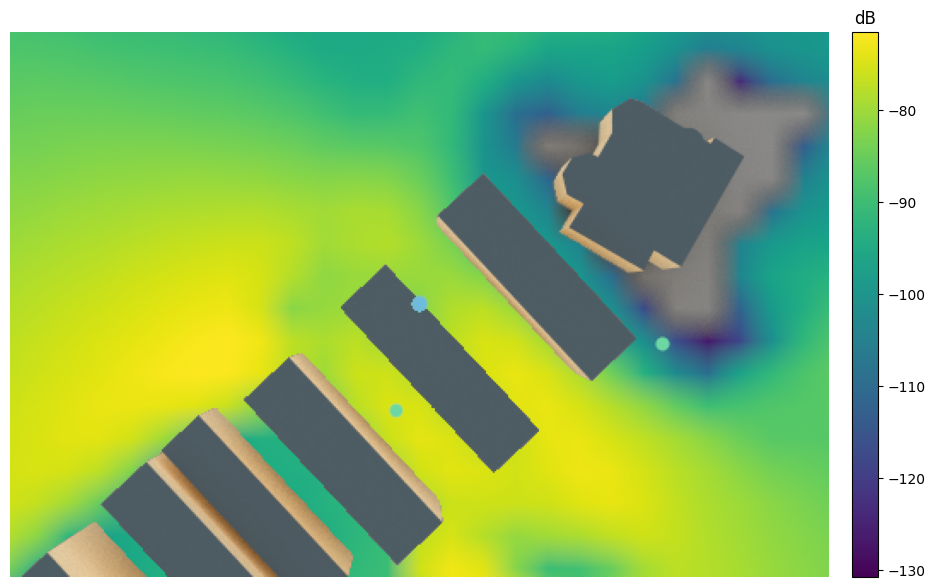

In [34]:
# Create new camera
tx_pos = scene.transmitters["tx"].position.numpy()
bird_pos = tx_pos.copy()
bird_pos[-1] = 150 # Set height of coverage map to 1000m above tx
bird_pos[-2]-= 0.01 # Slightly move the camera for correct orientation

# Create new camera
bird_cam = Camera("birds_view", position=bird_pos, look_at=tx_pos)
scene.add(bird_cam)

scene.render("birds_view", coverage_map=cm, resolution=resolution, num_samples=512); 